# Stock Risk Profiling with PCA and Clustering

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, sys, math
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

sns.set(context='notebook', style='whitegrid')

In [2]:
TICKERS = [
    'PETR4.SA', 'VALE3.SA', 'ITUB4.SA',  # Brazil
    'AAPL', 'MSFT', 'GOOGL',             # USA
    'MC.PA', 'NESN.SW'                   # Europe
]
START = '2020-01-01'
END = None
PERIODS_PER_YEAR = 252
RISK_FREE_PER_PERIOD = 0.0
RANDOM_STATE = 42

In [3]:
def compute_drawdown(return_series: pd.Series) -> float:
    wealth = (1 + return_series.fillna(0)).cumprod()
    running_max = wealth.cummax()
    drawdown = (wealth / running_max) - 1.0
    return float(drawdown.min())

def downside_deviation(returns: pd.Series, mar: float = 0.0) -> float:
    downside = np.minimum(0, returns - mar)
    return float(np.sqrt((downside ** 2).mean()))

def sharpe_ratio(returns: pd.Series, rf: float = 0.0, periods_per_year: int = 252) -> float:
    excess = returns - rf
    mean = excess.mean() * periods_per_year
    vol = excess.std(ddof=1) * np.sqrt(periods_per_year)
    return float(np.nan) if vol == 0 else float(mean / vol)

In [4]:
prices = yf.download(TICKERS, start=START, end=END, auto_adjust=True)['Close']
prices = prices.dropna(how='all')
returns = prices.pct_change().dropna(how='all')

features = {}
for col in returns.columns:
    r = returns[col].dropna()
    if r.empty:
        continue
    mean_daily = r.mean()
    vol_daily = r.std(ddof=1)
    dd = compute_drawdown(r)
    ddv = downside_deviation(r, mar=0.0)
    shrp = sharpe_ratio(r, rf=RISK_FREE_PER_PERIOD, periods_per_year=PERIODS_PER_YEAR)
    features[col] = {
        'ret_daily_mean': mean_daily,
        'ret_ann_mean': mean_daily * PERIODS_PER_YEAR,
        'vol_daily': vol_daily,
        'vol_ann': vol_daily * math.sqrt(PERIODS_PER_YEAR),
        'max_drawdown': dd,
        'downside_dev': ddv,
        'sharpe_ann': shrp,
        'n_obs': len(r)
    }

feat_df = pd.DataFrame(features).T.dropna().sort_index()

[*********************100%***********************]  8 of 8 completed


In [5]:
X = feat_df.select_dtypes(include=[np.number]).copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=min(5, X.shape[1]))
X_pca = pca.fit_transform(X_scaled)

In [6]:
explained = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(pca.n_components_)],
    'Explained_Variance_Ratio': pca.explained_variance_ratio_,
    'Cumulative': np.cumsum(pca.explained_variance_ratio_)
})

In [7]:
sil_scores = {}
max_k = min(10, len(feat_df))
for k in range(2, max_k):
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
    labels = km.fit_predict(X_pca[:, :2])
    sil_scores[k] = silhouette_score(X_pca[:, :2], labels)

In [8]:
import pandas as pd
sil_df = pd.DataFrame({'k': list(sil_scores.keys()), 'silhouette': list(sil_scores.values())}).sort_values('k')
best_k = int(sil_df.loc[sil_df['silhouette'].idxmax(), 'k']) if not sil_df.empty else 3

km = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init='auto')
labels_km = km.fit_predict(X_pca[:, :2])

agg = AgglomerativeClustering(n_clusters=best_k)
labels_agg = agg.fit_predict(X_pca[:, :2])

result = feat_df.copy()
result['PC1'] = X_pca[:, 0]
result['PC2'] = X_pca[:, 1]
result['cluster_km'] = labels_km
result['cluster_agg'] = labels_agg

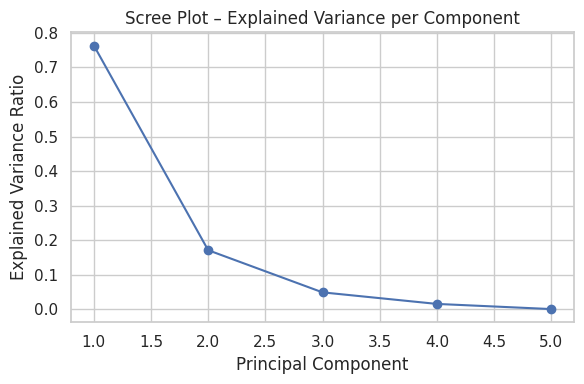

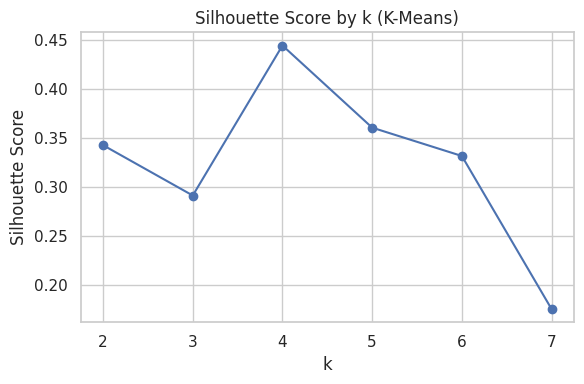

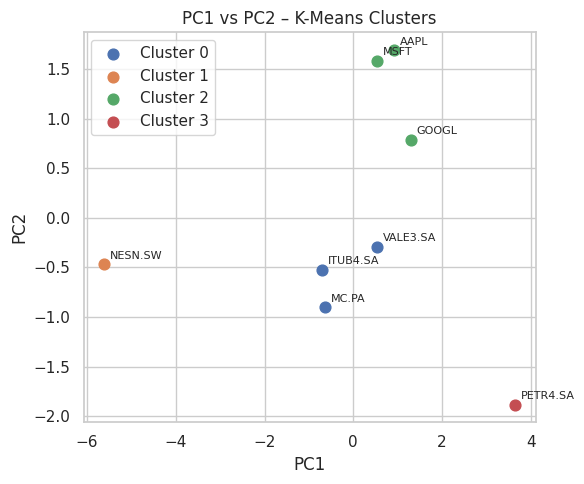

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scree plot
plt.figure(figsize=(6,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot – Explained Variance per Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.tight_layout()
plt.show()

# Silhouette plot
plt.figure(figsize=(6,4))
plt.plot(sil_df['k'], sil_df['silhouette'], marker='o')
plt.title('Silhouette Score by k (K-Means)')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

# PCA scatter with clusters
plt.figure(figsize=(6,5))
palette = sns.color_palette(n_colors=best_k)
for cl in sorted(np.unique(labels_km)):
    sel = labels_km == cl
    plt.scatter(result.loc[sel, 'PC1'], result.loc[sel, 'PC2'], label=f'Cluster {cl}', s=60)
for t in result.index:
    plt.annotate(t, (result.loc[t, 'PC1'], result.loc[t, 'PC2']), fontsize=8, xytext=(4,4), textcoords='offset points')
plt.title('PC1 vs PC2 – K-Means Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Optional: save tabular results locally (not required for rendering on GitHub)
os.makedirs('../results', exist_ok=True)
result.to_csv('../results/pca_clustering_results.csv', index=True)
print('Saved: ../results/pca_clustering_results.csv')

Saved: ../results/pca_clustering_results.csv
